In [1]:
# !pip install tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from transformers import ViTForImageClassification
from scipy import stats

In [19]:
label_to_int = {'slecht': 0, 'matig': 1, 'redelijk': 2, 'goed': 3, 'other': 4}
images_folder_path = "C:/Users/steve/OneDrive/Bureaublad/bomen"


In [20]:
class CustomImageDataset1(Dataset):
    """
    A custom dataset class for handling image data with corresponding labels.

    Args:
        images (list): List of image file paths.
        labels (list): List of corresponding labels.
        transforms (callable, optional): Optional transforms to be applied to the images.
        samples_per_class (int, optional): Number of samples per class to consider.

    Attributes:
        images (list): List of image file paths.
        labels (list): List of corresponding labels.
        transforms (callable, optional): Optional transforms to be applied to the images.
    """

    def __init__(self, images, labels, transforms=None, samples_per_class=None):
        self.images = images
        self.labels = [label_to_int[label] for label in labels]
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
    
    # Alternative for load_images
    # This function will parse the filenames and extract labels
    def load_images_and_labels(images_folder_path):
        images = []
        labels = []
        for filename in os.listdir(images_folder_path):
            if filename.endswith('.jpg'):
                # Split the filename into imageindex and label
                parts = filename.split('_')
                label_part = parts[-1]  # The label is the last part after splitting (still has .jpg)
                label = label_part.split('.')[0]  # Remove the file extension from the label
                images.append(os.path.join(images_folder_path, filename))
                labels.append(label)
        return images, labels

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        if self.transforms:
            image = self.transforms(image)

        return image, label

class CustomImageDataset(Dataset):
    """
    A custom dataset class for handling image data with corresponding labels.

    Args:
        images (list): List of image file paths.
        labels (list): List of corresponding labels for each image.
        transforms (callable, optional): Optional transforms to be applied to the images.
        sampling_factors (dict, optional): Optional dictionary specifying the sampling factors for each label.

    Attributes:
        images (list): List of image file paths.
        labels (list): List of corresponding labels for each image.
        transforms (callable): Optional transforms to be applied to the images.
        sampling_factors (dict): Optional dictionary specifying the sampling factors for each label.

    Methods:
        __len__(): Returns the total length of the dataset.
        __getitem__(idx): Returns the image and label at the given index.

    """

    def __init__(self, images, labels, transforms=None, sampling_factors=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.sampling_factors = sampling_factors if sampling_factors is not None else {label: 1 for label in set(labels)}

    def __len__(self):
        # Calculate total length considering sampling factors
        total_length = 0
        for label in self.labels:
            total_length += self.sampling_factors[label]
        return total_length

    def __getitem__(self, idx):
        # Find the actual image index based on the sampling factor
        actual_idx = idx
        for i, label in enumerate(self.labels):
            if actual_idx < self.sampling_factors[label]:
                break
            actual_idx -= self.sampling_factors[label]


        image = Image.open(self.images[i])
        label = self.labels[i]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        # Process image
        if self.transforms:
            image = self.transforms(image)

        return image, label_to_int[label]

def load_images(folder_path):
    print("Loading images...")

    images = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            images.append(img_path)
            labels.append(class_folder)
    print("Total images loaded:", len(images))
    return images, labels


# Alternative for load_images
# This function will parse the filenames and extract labels
def load_images_and_labels(images_folder_path):
    images = []
    labels = []
    for filename in os.listdir(images_folder_path):
        if filename.endswith('.jpg'):
            # Split the filename into imageindex and label
            parts = filename.split('_')
            label_part = parts[-1]  # The label is the last part after splitting (still has .jpg)
            label = label_part.split('.')[0]  # Remove the file extension from the label
            images.append(os.path.join(images_folder_path, filename))
            labels.append(label)
    return images, labels


def split_dataset(images, labels, train_ratio=0.6, val_ratio=0.2):
    # Split dataset into train, validation, and test
    print("Splitting dataset...")
    dataset = list(zip(images, labels))
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    train_set = dataset[:train_size]
    val_set = dataset[train_size:train_size + val_size]
    test_set = dataset[train_size + val_size:]
    print(f"Dataset split into {len(train_set)} training, {len(val_set)} validation, and {len(test_set)} test images.")
    return train_set, val_set, test_set

def count_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

def calculate_sampling_factors(train_set):
    label_counts = Counter(label for _, label in train_set)
    min_samples = min(label_counts.values())

    # Calculate sampling factor for each class
    sampling_factors = {label: round(min_samples / count) for label, count in label_counts.items()}
    return sampling_factors

def create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size):
    # Define transformations
    print("Creating dataloaders...")

    train_transforms = transforms.Compose([
        transforms.RandomCrop(224),  # Specify size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    
    train_dataset = CustomImageDataset([i[0] for i in train_set], [i[1] for i in train_set], transforms=train_transforms, sampling_factors=sampling_factors)
    val_dataset = CustomImageDataset([i[0] for i in val_set], [i[1] for i in val_set], transforms=val_test_transforms)
    test_dataset = CustomImageDataset([i[0] for i in test_set], [i[1] for i in test_set], transforms=val_test_transforms)
    # print('Dataset', train_dataset[0])
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Dataloaders created.")
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

def calculate_samples_per_class(class_distribution):
    min_count = min(class_distribution.values())
    samples_per_class = {label_to_int[cls]: min_count // count for cls, count in class_distribution.items()}
    return samples_per_class



def load_data(folder1):
    # images, labels = load_images(folder1)
    images, labels = load_images_and_labels(folder1)
    train_set, val_set, test_set = split_dataset(images, labels)

    # Print class distribution
    train_class_distribution = count_class_distribution(train_set)
    val_class_distribution = count_class_distribution(val_set)
    test_class_distribution = count_class_distribution(test_set)

    print("Training set class distribution:", train_class_distribution)
    print("Validation set class distribution:", val_class_distribution)
    print("Test set class distribution:", test_class_distribution)

    # sampling_factors = calculate_sampling_factors(train_set)
    # sampling_factors = {'rice': 1, 'other': 2, 'sugarcane': 6, 'cassava': 12, 'maize': 10}
    sampling_factors = {'slecht': 1, 'matig': 1, 'redelijk': 1, 'goed': 1, 'other': 1}
    print('Sampling factors: ', sampling_factors)
    train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size=8)

    return train_loader, val_loader, test_loader

In [21]:
def extract_patches(image, patch_size, stride):
    patches = []
    c, height, width = image.size()

    for y in range(0, height - patch_size[1] + 1, stride):
        for x in range(0, width - patch_size[0] + 1, stride):
            patch = image[:, y:y + patch_size[1], x:x + patch_size[0]]
            patches.append(patch)

    return patches

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in progress_bar:

        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)

        #For ViT
        logits = outputs.logits  # Extract the logits
        loss = criterion(logits, labels)

        # loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        # _, predicted = torch.max(outputs, 1)
        _, predicted = torch.max(outputs.logits, 1)

        correct = (predicted == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=correct/len(labels))

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

        # For F1 score calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    return avg_loss, accuracy, f1, per_class_f1



def validate_or_test(model, loader, criterion, device, patch_size, stride, desc='Val'):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            batch_preds = []

            for image in images:
                # # Apply sliding window approach
                # patches = extract_patches(image, patch_size, stride)
                # patches = torch.stack(patches).to(device)

                # # Aggregate predictions for each patch
                # patch_outputs = model(patches)
                # logits = patch_outputs.logits  # Extract the logits
                # patch_predictions = torch.mean(logits, dim=0)
                # patch_predictions = torch.mean(patch_outputs, dim=0)
                # batch_preds.append(patch_predictions)

                # Calculate the mode of the patch predictions

                patches = extract_patches(image, patch_size, stride)
                patches = torch.stack(patches).to(device)

                # Aggregate predictions for each patch
                patch_outputs = model(patches)
                logits = patch_outputs.logits  # Extract the logits

                # Calculate mode for each patch prediction
                modes, _ = torch.mode(logits, dim=0)
                batch_preds.append(modes)

            print(batch_preds)
            batch_preds = torch.stack(batch_preds)
            loss = criterion(batch_preds, labels)
            total_loss += loss.item()

            _, predicted = torch.max(batch_preds, 1)
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return avg_loss, accuracy, f1, per_class_f1

def train_and_evaluate(model, train_loader, val_loader, test_loader, model_name, num_epochs=5, patch_size=(224, 224), stride=30):
    # Criterion, Optimizer, and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    global best_val_f1
    global best_model_weights

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_f1, train_f1_per_class = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Train F1 Score Per Class ', train_f1_per_class)

        val_loss, val_accuracy, val_f1, val_f1_per_class = validate_or_test(model, val_loader, criterion, device, patch_size, stride, desc='Val')
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')
        print(f'Val F1 Score Per Class ', val_f1_per_class)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_weights = model.state_dict()  # Save the best model weights

        # Save intermediate model weights
        torch.save(model.state_dict(), imagesRoot+f'{model_name}_epoch_{epoch}.pth')

        scheduler.step()


    test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(model, test_loader, criterion, device, patch_size, stride, desc='Test')
    print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
    print(f'Test F1 Score Per Class ', test_f1_per_class)

    # After training is complete, load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model weights
    torch.save(model.state_dict(), imagesRoot+f'{model_name}.pth')
    return model

Splitting dataset...
Dataset split into 3 training, 1 validation, and 1 test images.
Training set class distribution: {'slecht': 1, 'other': 1, 'redelijk': 1}
Validation set class distribution: {'goed': 1}
Test set class distribution: {'matig': 1}
Sampling factors:  {'slecht': 1, 'matig': 1, 'redelijk': 1, 'goed': 1, 'other': 1}
Creating dataloaders...
Dataloaders created.
1 1 1


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

C:\Users\steve\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\steve\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 1.6248, Accuracy: 0.0000, F1 Score: 0.0000
Train F1 Score Per Class  [0. 0. 0.]


[tensor([ 0.0478, -0.3503,  0.0995, -0.2897, -0.0349])]


C:\Users\steve\AppData\Local\Temp\ipykernel_16812\3428606769.py:123: RuntimeWarning: invalid value encountered in true_divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


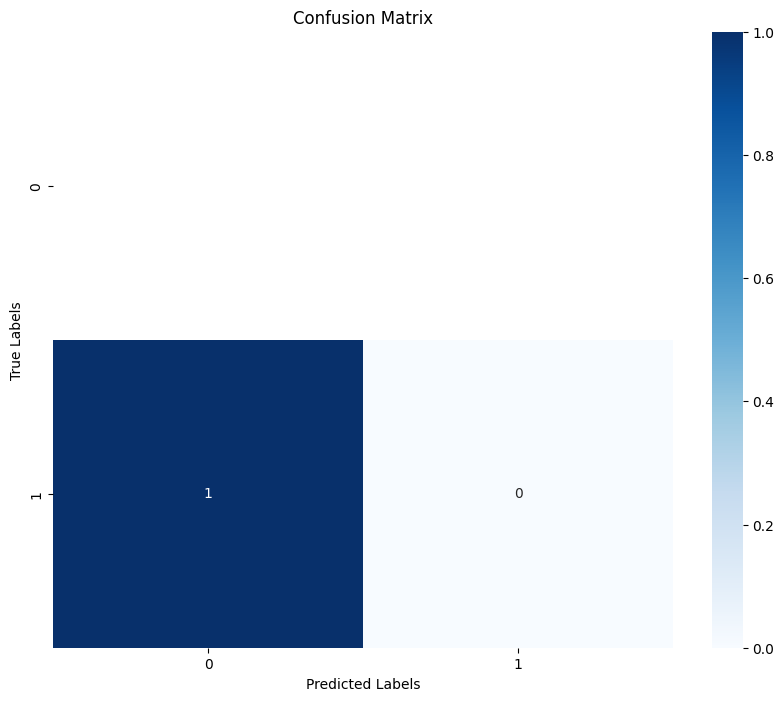

Epoch 1, Validation Loss: 1.8097, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0.]


Epoch 2, Train Loss: 1.4318, Accuracy: 0.6667, F1 Score: 0.5556
Train F1 Score Per Class  [0.         1.         0.66666667]


[tensor([ 0.1124, -0.4527,  0.2612, -0.3433, -0.0966])]


C:\Users\steve\AppData\Local\Temp\ipykernel_16812\3428606769.py:123: RuntimeWarning: invalid value encountered in true_divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


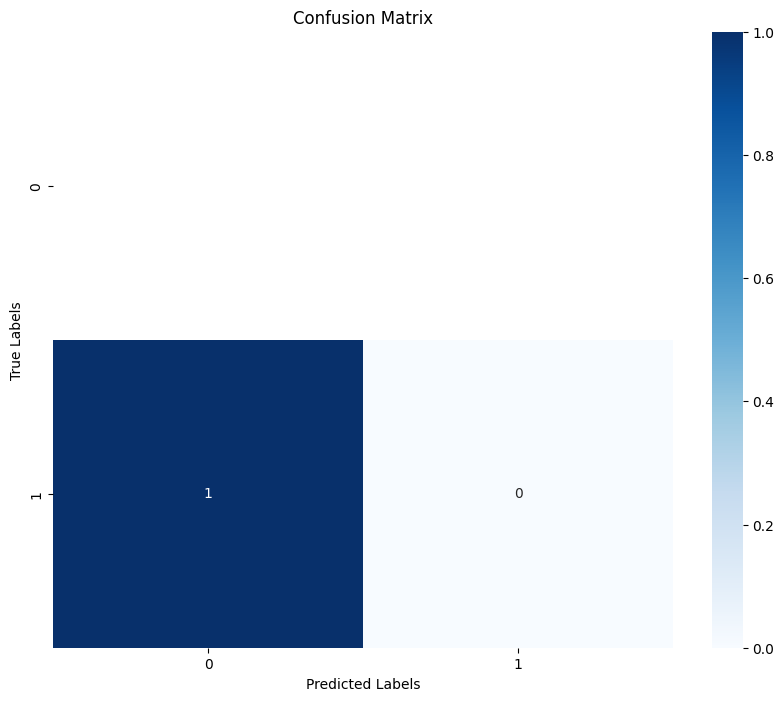

Epoch 2, Validation Loss: 1.8846, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0.]


Epoch 3, Train Loss: 1.1809, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1.]


[tensor([ 0.1567, -0.5567,  0.5096, -0.4907, -0.0874])]


C:\Users\steve\AppData\Local\Temp\ipykernel_16812\3428606769.py:123: RuntimeWarning: invalid value encountered in true_divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


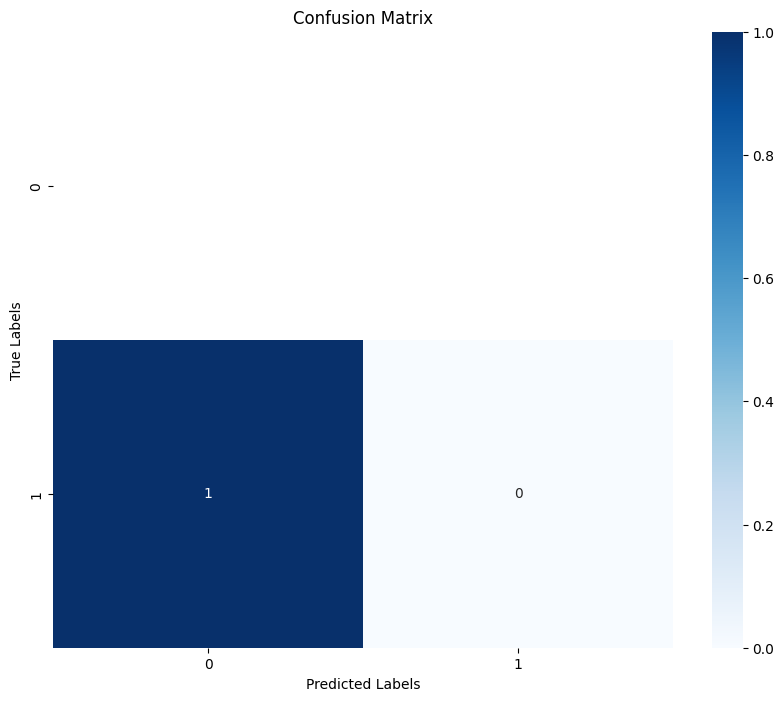

Epoch 3, Validation Loss: 2.0873, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0.]


Epoch 4, Train Loss: 0.9951, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1.]


[tensor([ 0.1762, -0.6919,  0.4014, -0.6390, -0.0548])]


C:\Users\steve\AppData\Local\Temp\ipykernel_16812\3428606769.py:123: RuntimeWarning: invalid value encountered in true_divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


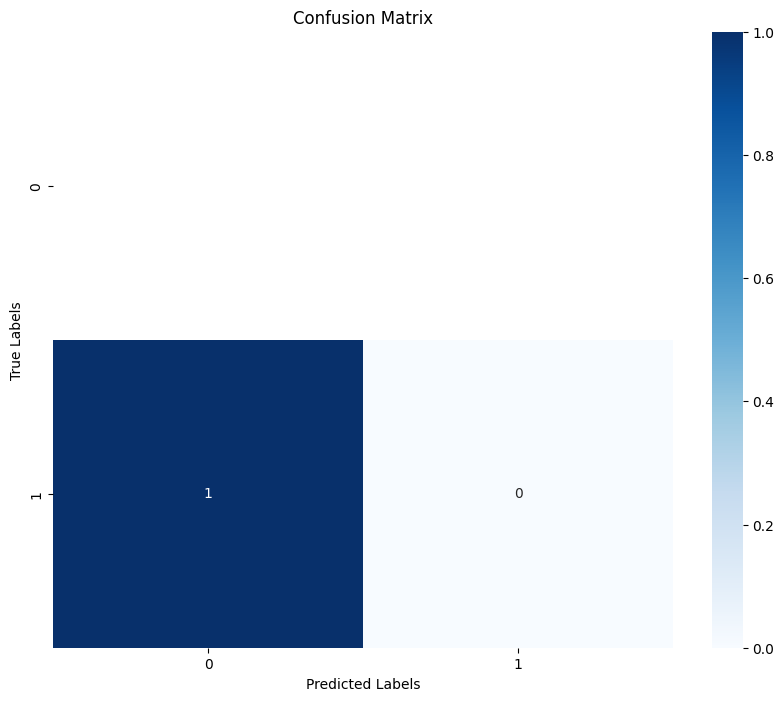

Epoch 4, Validation Loss: 2.1784, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0.]


Epoch 5, Train Loss: 0.8425, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1.]


[tensor([ 0.1208, -0.7947,  0.5185, -0.7418, -0.0978])]


C:\Users\steve\AppData\Local\Temp\ipykernel_16812\3428606769.py:123: RuntimeWarning: invalid value encountered in true_divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


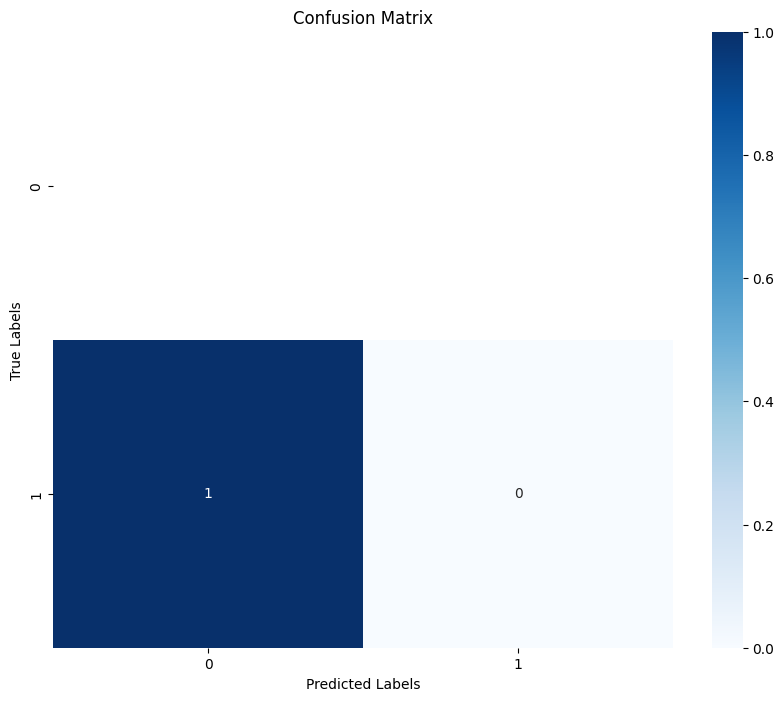

Epoch 5, Validation Loss: 2.2770, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0.]


Epoch 6, Train Loss: 0.7629, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1.]


Val:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# Call the main function with the path to folder1
# imagesRoot = '/content/drive/MyDrive/GSV-CropType-Thailand/images/'

# imagesRoot = images_folder_path
# images_folder_path = "C:/Users/steve/OneDrive/Bureaublad/bomen/"
# path_to_images = imagesRoot + '/validationByClassOther1'

path_to_images = images_folder_path
train_loader, val_loader, test_loader = load_data(path_to_images)

def load_pretrained_vit(num_labels):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_labels)
    return model

num_classes = 5  # Adjust as per your dataset
num_epochs = 20
# Load the pretrained ResNet-50 model
# model = models.resnet50(pretrained=True)
vit_model = load_pretrained_vit(num_labels=num_classes)

# model.fc = nn.Linear(model.fc.in_features, num_classes)
# Initialize best F1 score for validation

best_val_f1 = 0.0
best_model_weights = None
model_name = 'ViT1-Thailand-4cropsOther-lr2e-4-ep10'
trained_model = train_and_evaluate(vit_model, train_loader, val_loader, test_loader, model_name, num_epochs)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
patch_size=(224, 224)
stride=30
test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(trained_model, test_loader, criterion, device, patch_size, stride, desc='Test')
print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
print(f'Test F1 Score Per Class ', test_f1_per_class)